In [ ]:
!pip install -U transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 36.5 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 5.0.0
    Uninstalling transformers-5.0.0:
      Successfully uninstalled transformers-5.0.0


# Download my final submitted model

In [ ]:
!pip install -U gdown

!gdown --folder https://drive.google.com/drive/folders/1DGxcH8g-_DFfyW3ml6dbOv_IWbVxT-pv -O /content/DeBERTa_PCL_Model

print("Model downloaded")

Retrieving folder contents
Processing file 1FYiShYOelKJ8hFLMqQUE4Bn0nTPRBh8E config.json
Processing file 1dO_Uwfxq0svxhUoMbbI000CvDdBriYV8 model.safetensors
Processing file 1rksoCRp7ux0EVyZqCUpm6gdjJm3Rd9Mp training_args.bin
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1FYiShYOelKJ8hFLMqQUE4Bn0nTPRBh8E
To: /content/DeBERTa_PCL_Model/config.json
100% 854/854 [00:00<00:00, 3.64MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1dO_Uwfxq0svxhUoMbbI000CvDdBriYV8
From (redirected): https://drive.google.com/uc?id=1dO_Uwfxq0svxhUoMbbI000CvDdBriYV8&confirm=t&uuid=0d0dea4c-2e9d-410b-bc7f-203791f0324e
To: /content/DeBERTa_PCL_Model/model.safetensors
100% 557M/557M [00:08<00:00, 62.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1rksoCRp7ux0EVyZqCUpm6gdjJm3Rd9Mp
To: /content/DeBERTa_PCL_Model/training_args.bin
100% 5.20k/5.20k [00:00<00:00, 18.4MB/s]
Downloa

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer
from collections import Counter
import numpy as np

save_path = "/content/DeBERTa_PCL_Model"

loaded_model = AutoModelForSequenceClassification.from_pretrained(save_path)
loaded_tokenizer = AutoTokenizer.from_pretrained(save_path)

loaded_model.to("cuda")

trainer = Trainer(model=loaded_model)

Loading weights:   0%|          | 0/200 [00:00<?, ?it/s]

# Fetch data

In [ ]:
from urllib import request

def read_to_file(url, file):
  with request.urlopen(url) as f, open(file,'w') as outf:
    a = f.read()
    outf.write(a.decode('utf-8'))

# Data
read_to_file(
    'https://raw.githubusercontent.com/CRLala/NLPLabs-2024/refs/heads/main/Dont_Patronize_Me_Trainingset/dontpatronizeme_pcl.tsv',
    'dontpatronizeme_pcl.tsv'
)

# Train/dev set
read_to_file(
    'https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/refs/heads/master/semeval-2022/practice%20splits/dev_semeval_parids-labels.csv',
    'dev_semeval_parids-labels.csv'
)
read_to_file(
    'https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/refs/heads/master/semeval-2022/practice%20splits/train_semeval_parids-labels.csv',
    'train_semeval_parids-labels.csv'
)

# Test set
read_to_file(
    'https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/refs/heads/master/semeval-2022/TEST/task4_test.tsv',
    'task4_test.tsv'
)

# DontPatronizeMe module
read_to_file(
    'https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py',
    'dont_patronize_me.py'
)

# Load data

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from dont_patronize_me import DontPatronizeMe
dpm = DontPatronizeMe('.', 'task4_test.tsv')


def load_data(file_path):
    dpm.load_task1()
    df = dpm.train_task1_df

    df = df.dropna(subset=['text', 'label'])
    df['label'] = pd.to_numeric(df['label'], errors='coerce')
    df = df.dropna(subset=['label'])
    df['label'] = df['label'].astype(int)
    df['text'] = df['text'].apply(lambda x: str(x).strip())

    return df

def load_test():
    dpm.load_test()
    df = dpm.test_set_df

    df = df.dropna(subset=['text'])
    df['text'] = df['text'].apply(lambda x: str(x).strip())

    return df

def preset_data_split(data):
    trids = pd.read_csv('train_semeval_parids-labels.csv')
    teids = pd.read_csv('dev_semeval_parids-labels.csv')

    trids['par_id'] = trids['par_id'].astype(str)
    teids['par_id'] = teids['par_id'].astype(str)

    ref_data = (data[['par_id', 'keyword', 'text', 'label']]
                .drop_duplicates(subset=['par_id']))

    train = trids[['par_id']].merge(ref_data, on='par_id', how='left')
    val = teids[['par_id']].merge(ref_data, on='par_id', how='left')

    return train, val

def local_data_split(df):
    train, val = train_test_split(
        df,
        test_size=0.15,
        random_state=42,
        stratify=df['label']
    )

    return train, val

def balance_data(raw_train):
    df_pos = raw_train[raw_train['label'] == 1]
    df_neg = raw_train[raw_train['label'] == 0]

    df_neg_sampled = df_neg.sample(n=len(df_pos) * 3, random_state=42) # 1:3 undersampling
    train_balanced = pd.concat([df_pos, df_neg_sampled]).sample(frac=1, random_state=42)

    return train_balanced
# train_df, val_df = balance_data(*preset_data_split(load_data('dontpatronizeme_pcl.tsv')))
data = load_data('dontpatronizeme_pcl.tsv')
raw_train, dev_df = preset_data_split(data)
internal_train, val_df = local_data_split(raw_train)
train_df = balance_data(raw_train)

test_df = load_test()
(train_df, val_df, dev_df, test_df)


(     par_id        keyword                                               text  \
 7401   7316       hopeless  """ The dull slur in his slow , loud voice tel...   
 442    6334        in-need  Destitute , or clutching a smart-phone ? Rathe...   
 5211   4875  poor-families  This community based development programme is ...   
 6970   6832        refugee  Uhuru and the diplomats from the 15 -- member ...   
 7428   7348        migrant  Militias in Libya have taken advantage of the ...   
 ...     ...            ...                                                ...   
 1505    790          women  """ We know that the success of any society de...   
 5750   5468     vulnerable  Bitter Winds 's description no longer says tha...   
 2688   2112        refugee  Austrian Foreign Minister Sebastian Kurz 's pr...   
 8170   8157  poor-families  The governor said the funds would be channeled...   
 8204   8193       homeless  It is difficult to imagine the kind of world w...   
 
       label  

# Exploratory Data Analysis

/tmp/ipython-input-700/1906703756.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=raw_train, x='label', ax=axes[0], palette=palette)


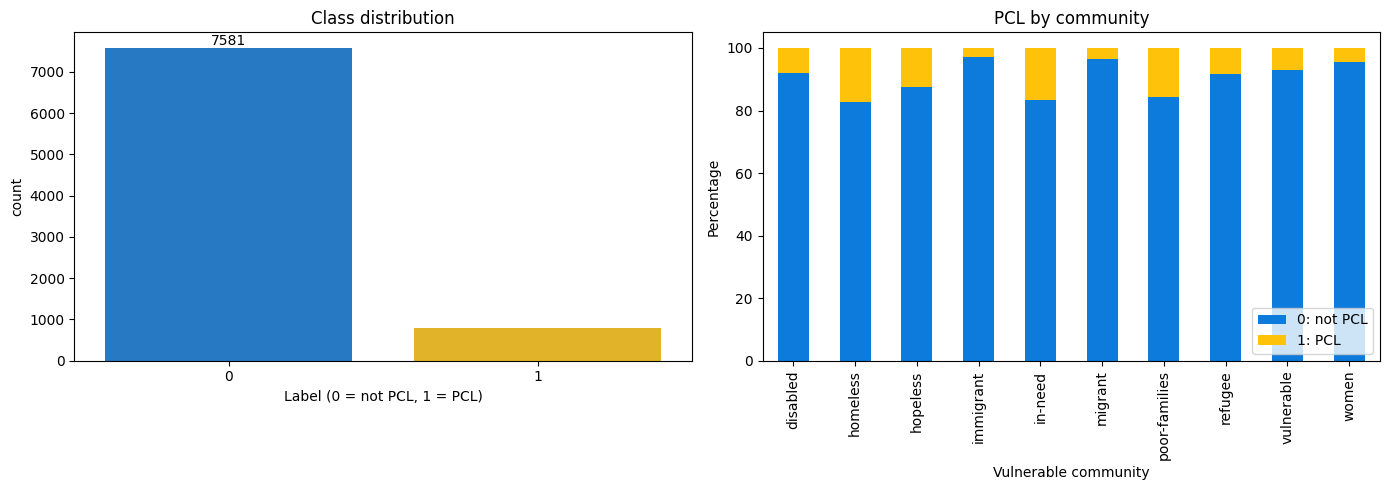

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
palette=['#0C7BDC', '#FFC20A']

sns.countplot(data=raw_train, x='label', ax=axes[0], palette=palette)
axes[0].set_title("Class distribution")
axes[0].set_xlabel("Label (0 = not PCL, 1 = PCL)")
axes[0].bar_label(axes[0].containers[0])

comm_dist = pd.crosstab(raw_train['keyword'], raw_train['label'], normalize='index') * 100
comm_dist.plot(kind='bar', stacked=True, ax=axes[1], color=palette)
axes[1].set_title("PCL by community")
axes[1].set_ylabel("Percentage")
axes[1].set_xlabel("Vulnerable community")
axes[1].legend(['0: not PCL', '1: PCL'], loc='lower right')

plt.tight_layout()
plt.show()

/tmp/ipython-input-700/430687871.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[val for word, val in top_bigrams_nopcl],
/tmp/ipython-input-700/430687871.py:16: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=[val for word, val in top_bigrams_nopcl],
/tmp/ipython-input-700/430687871.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[val for word, val in top_bigrams_pcl],
/tmp/ipython-input-700/430687871.py:21: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=[val for word, val in top_bigr

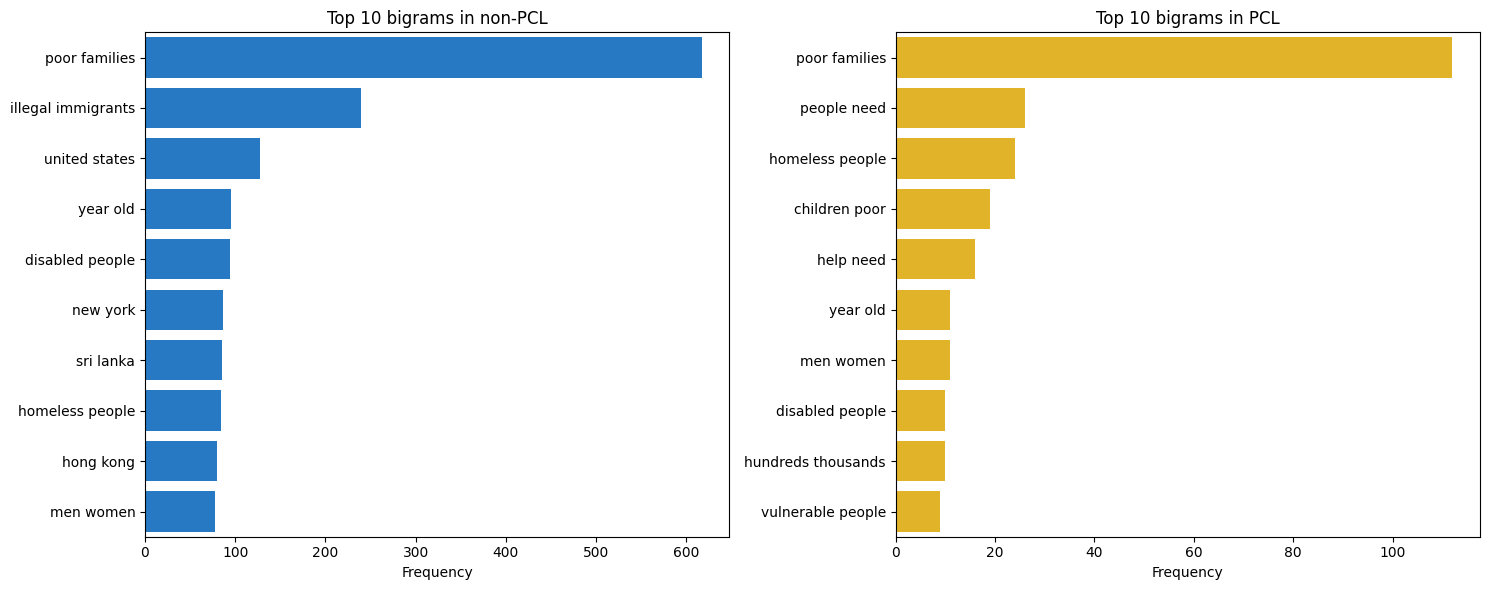

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngrams(corpus, n=10, ngram_range=(2,2)):
    vec = CountVectorizer(stop_words='english', ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

top_bigrams_pcl = get_top_ngrams(raw_train[raw_train['label']==1]['text'], n=10)
top_bigrams_nopcl = get_top_ngrams(raw_train[raw_train['label']==0]['text'], n=10)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.barplot(x=[val for word, val in top_bigrams_nopcl],
            y=[word for word, val in top_bigrams_nopcl], ax=axes[0], palette=[palette[0]])
axes[0].set_title("Top 10 bigrams in non-PCL")
axes[0].set_xlabel("Frequency")

sns.barplot(x=[val for word, val in top_bigrams_pcl],
            y=[word for word, val in top_bigrams_pcl], ax=axes[1], palette=[palette[1]])
axes[1].set_title("Top 10 bigrams in PCL")
axes[1].set_xlabel("Frequency")

plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

/tmp/ipython-input-700/807450770.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=raw_train, x='label', y='token_count', palette=['#0C7BDC', '#FFC20A'])


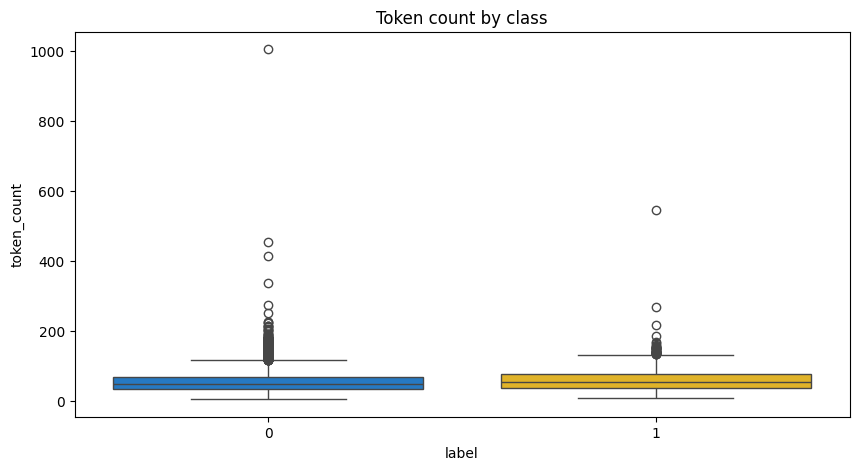

count    8375.000000
mean       55.908657
std        32.937143
min         5.000000
50%        49.000000
75%        69.000000
90%        95.000000
95%       115.300000
99%       160.260000
max      1005.000000
Name: token_count, dtype: float64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer

MODEL_NAME = "microsoft/deberta-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

raw_train['token_count'] = raw_train['text'].apply(lambda x: len(tokenizer.encode(str(x), add_special_tokens=True)))

plt.figure(figsize=(10,5))
sns.boxplot(data=raw_train, x='label', y='token_count', palette=['#0C7BDC', '#FFC20A'])
plt.title("Token count by class")
plt.show()

print(raw_train['token_count'].describe(percentiles=[0.75, 0.90, 0.95, 0.99]))

# Tokenization

In [ ]:
import numpy as np
import torch
from transformers import AutoTokenizer, TrainingArguments
from datasets import Dataset

MODEL_NAME = "microsoft/deberta-base"

MAX_LEN = 256
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
EPOCHS = 4

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

print(f"Balanced Train Size: {len(train_df)} (Pos: {train_df['label'].sum()})")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_func(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=MAX_LEN)

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

train_dataset = train_dataset.map(tokenize_func, batched=True)
val_dataset = val_dataset.map(tokenize_func, batched=True)

train_dataset.set_format("torch")
val_dataset.set_format("torch")

Using device: cuda
Balanced Train Size: 3176 (Pos: 794)


Map:   0%|          | 0/3176 [00:00<?, ? examples/s]

Map:   0%|          | 0/1257 [00:00<?, ? examples/s]

# Training

In [ ]:
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import f1_score, accuracy_score, classification_report

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    f1 = f1_score(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {"f1": f1, "accuracy": acc}

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

def fix_layernorm_keys(state_dict, prefix, local_metadata, strict, missing_keys, unexpected_keys, error_msgs):
    keys = list(state_dict.keys())
    for key in keys:
        if 'LayerNorm.gamma' in key:
            new_key = key.replace('LayerNorm.gamma', 'LayerNorm.weight')
            state_dict[new_key] = state_dict.pop(key)
        elif 'LayerNorm.beta' in key:
            new_key = key.replace('LayerNorm.beta', 'LayerNorm.bias')
            state_dict[new_key] = state_dict.pop(key)
model._register_load_state_dict_pre_hook(fix_layernorm_keys)

training_args = TrainingArguments(
    output_dir="./deberta_v1_results",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=16,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    fp16=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_steps=50,
    report_to="none"
)

weight_for_0 = len(train_df) / (2 * len(train_df[train_df['label'] == 0]))
weight_for_1 = len(train_df) / (2 * len(train_df[train_df['label'] == 1]))
class_weights = torch.tensor([weight_for_0, weight_for_1], dtype=torch.float).to(device)

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

print("training started")
trainer.train()

raw_pred, labels, _ = trainer.predict(val_dataset)
final_preds = np.argmax(raw_pred, axis=1)

print(classification_report(labels, final_preds))

Using device: cuda
Balanced Train Size: 3176 (Pos: 794)


Map:   0%|          | 0/3176 [00:00<?, ? examples/s]

Map:   0%|          | 0/1257 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/196 [00:00<?, ?it/s]

DebertaForSequenceClassification LOAD REPORT from: microsoft/deberta-base
Key                                     | Status     | 
----------------------------------------+------------+-
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED | 
lm_predictions.lm_head.bias             | UNEXPECTED | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED | 
pooler.dense.bias                       | MISSING    | 
classifier.weight                       | MISSING    | 
classifier.bias                         | MISSING    | 
pooler.dense.weight                     | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


model.safetensors:   0%|          | 0.00/559M [00:00<?, ?B/s]

training started


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.448373,0.481457,0.440546,0.771679
2,0.316891,0.415778,0.469636,0.791567
3,0.195549,0.374798,0.625000,0.890215
4,0.071992,0.369490,0.644444,0.898170


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1138
           1       0.48      0.97      0.64       119

    accuracy                           0.90      1257
   macro avg       0.74      0.93      0.79      1257
weighted avg       0.95      0.90      0.91      1257



# Save model to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

save_path = "/content/drive/MyDrive/DeBERTa_PCL_Model"
trainer.save_model(save_path)

print("Model saved to google drive")

Mounted at /content/drive


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Model saved to google drive


# Load model from google drive

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer
from collections import Counter
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

save_path = "/content/drive/MyDrive/DeBERTa_PCL_Model"

loaded_model = AutoModelForSequenceClassification.from_pretrained(save_path)
loaded_tokenizer = AutoTokenizer.from_pretrained(save_path)

loaded_model.to("cuda")

trainer = Trainer(model=loaded_model)

# Threshold tuning

In [ ]:
from sklearn.metrics import f1_score, classification_report, precision_score, recall_score
import numpy as np

def predict_probabilities(dataset):
  raw_pred, labels, _ = trainer.predict(dataset)
  probs = torch.nn.functional.softmax(torch.tensor(raw_pred), dim=-1).numpy()
  pcl_probs = probs[:, 1]
  return pcl_probs, labels

pcl_probs, labels = predict_probabilities(val_dataset)

best_f1 = 0
best_thresh = 0.5

for thresh in np.arange(0.02, 0.99, 0.02):
    preds = (pcl_probs >= thresh).astype(int)
    current_f1 = f1_score(labels, preds)
    p = precision_score(labels, preds, zero_division=0)
    r = recall_score(labels, preds, zero_division=0)

    print(f"thresh {thresh:.2f} | f1 {current_f1:.4f} | precision {p:.2f} | recall {r:.2f}")

    if current_f1 > best_f1:
        best_f1 = current_f1
        best_thresh = thresh

print(f"\nbest thresh {best_thresh:.2f} | f1 {best_f1:.4f}")

final_preds = (pcl_probs >= best_thresh).astype(int)
print(classification_report(labels, final_preds))

thresh 0.02 | f1 0.5327 | precision 0.36 | recall 0.99
thresh 0.04 | f1 0.5598 | precision 0.39 | recall 0.98
thresh 0.06 | f1 0.5735 | precision 0.40 | recall 0.98
thresh 0.08 | f1 0.5778 | precision 0.41 | recall 0.98
thresh 0.10 | f1 0.5879 | precision 0.42 | recall 0.98
thresh 0.12 | f1 0.5969 | precision 0.43 | recall 0.98
thresh 0.14 | f1 0.6015 | precision 0.43 | recall 0.98
thresh 0.16 | f1 0.6031 | precision 0.43 | recall 0.98
thresh 0.18 | f1 0.6062 | precision 0.44 | recall 0.98
thresh 0.20 | f1 0.6126 | precision 0.44 | recall 0.98
thresh 0.22 | f1 0.6174 | precision 0.45 | recall 0.98
thresh 0.24 | f1 0.6207 | precision 0.45 | recall 0.98
thresh 0.26 | f1 0.6223 | precision 0.46 | recall 0.98
thresh 0.28 | f1 0.6257 | precision 0.46 | recall 0.98
thresh 0.30 | f1 0.6290 | precision 0.46 | recall 0.98
thresh 0.32 | f1 0.6341 | precision 0.47 | recall 0.98
thresh 0.34 | f1 0.6393 | precision 0.47 | recall 0.98
thresh 0.36 | f1 0.6393 | precision 0.47 | recall 0.98
thresh 0.3

# Dev and test set prediction

In [ ]:
from collections import Counter
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf: outf.write('\n'.join([str(pi) for pi in p]))

In [ ]:
dev_dataset = Dataset.from_pandas(dev_df)
dev_dataset = dev_dataset.map(tokenize_func, batched=True)

dev_dataset.set_format("torch")

Map:   0%|          | 0/2094 [00:00<?, ? examples/s]

In [ ]:
dev_probs, dev_labels = predict_probabilities(dev_dataset)
dev_pred = (dev_probs >= best_thresh).astype(int)
print(Counter(dev_pred.tolist()))
print(f"F1: {f1_score(dev_pred, dev_labels):.4f} | precision {precision_score(dev_labels, dev_pred, zero_division=0):.2f} | recall {recall_score(dev_labels, dev_pred, zero_division=0):.2f}")
labels2file(dev_pred, 'dev.txt')
(dev_probs, dev_labels, dev_pred)

Counter({0: 1864, 1: 230})
F1: 0.5921 | precision 0.55 | recall 0.64


(array([0.00889073, 0.9946372 , 0.00322528, ..., 0.00276249, 0.03314578,
        0.00143029], dtype=float32),
 array([1, 1, 1, ..., 0, 0, 0]),
 array([0, 1, 0, ..., 0, 0, 0]))

In [ ]:
test_dataset = Dataset.from_pandas(test_df)
test_dataset = test_dataset.map(tokenize_func, batched=True)
test_dataset.set_format("torch")

test_probs, test_labels = predict_probabilities(test_dataset)
test_pred = (test_probs >= best_thresh).astype(int)
labels2file(test_pred, 'test.txt')
print(Counter(test_pred.tolist()))
(test_pred)

Map:   0%|          | 0/3832 [00:00<?, ? examples/s]

Counter({0: 3474, 1: 358})


array([0, 0, 0, ..., 0, 0, 0])

# Error analysis

In [20]:
import pandas as pd

val_errors_df = dev_df.copy()
val_errors_df['prediction'] = dev_pred
errors_only = val_errors_df[val_errors_df['label'] != val_errors_df['prediction']]
true_positives = val_errors_df[(val_errors_df['prediction'] == 1) & (val_errors_df['label'] == 1)]
true_negatives = val_errors_df[(val_errors_df['prediction'] == 0) & (val_errors_df['label'] == 0)]
false_positives = val_errors_df[(val_errors_df['prediction'] == 1) & (val_errors_df['label'] == 0)]
false_negatives = val_errors_df[(val_errors_df['prediction'] == 0) & (val_errors_df['label'] == 1)]

print(f"n: {len(dev_df)}")
print(f"Total errors: {len(errors_only)}\n")
print(f"True positives: {len(true_positives)}")
print(f"True negatives: {len(true_negatives)}\n")
print(f"False positives: {len(false_positives)}")
print(f"False negatives: {len(false_negatives)}\n")

pd.set_option('display.max_colwidth', None)
print("False positives")
display(false_positives[['text', 'keyword', 'label', 'prediction']].head(15))

print("False negatives")
display(false_negatives[['text', 'keyword', 'label', 'prediction']].head(15))

n: 2094
Total errors: 175

True positives: 127
True negatives: 1792

False positives: 103
False negatives: 72

False positives


,text,keyword,label,prediction
203,Marcos said the government should help poor families that try every possible means to survive . With Joel Zurbano <h> More from this Category :,poor-families,0,1
241,"""As she descended into a state of hopelessness , she decided to do """" one hopeful thing """" . She bought a Golden Retriever puppy called Bunker . Little did she know how much solace he would provide ...""",hopeless,0,1
257,"""Loach remains just as passionate about social injustice as when his TV play """" Cathy Come Home """" shocked viewers 50 years ago with its depiction of a slide into homelessness .""",homeless,0,1
262,""""""" This incident will not tear us down but rather strengthen us as an organization . We will continue our mission of helping Veterans in need . It is through your generous donations and the volunteers in Chapter 84 that we have been able to provide transportation service for Veterans to their appointments at VA facilities and to build wheel chair ramps at no cost to the Veteran . There is scarcely a family in Alexander County that has not witnessed Chapter 84 's Honor Guard perform Military Rites at a loved ones funeral . Last year , Chapter 84 voted to support ' Dental Care for Veterans , ' a program that is getting underway by the DAV Department of North Carolina . Through this program , Veterans will be able to receive primary dental care at no charge .""",in-need,0,1
281,The Jali family in Brown 's Farm was elated as the City of Cape Town donated wheelchairs to their disabled members .,disabled,0,1
286,"So , let the NPP government appointees look down upon the hardworking and selfless men and women at their own peril .",women,0,1
288,""""""" So we do need to heal ourselves as an Aboriginal Torres Strait islander community , but also as a nation . """" <h> A life of hope , not hopelessness""",hopeless,0,1
293,""""""" Nowadays Hong Kong diffuses hopelessness , worry and resentment . How can we walk further ? We have to pray to God that we wo n't give up even though we can not see immediate results , """" he said .""",hopeless,0,1
306,""""""" The government needs to come forward , and it needs to give resources to legal aid , so that those women and those families have their basic human rights and safety met , around representation and justice , the ability to navigate that Goliath of an office with a great deal of power , and to ensure they have the education and the advocacy that they need . """" <h> Child and Youth Advocate responds""",women,0,1
346,"Clans of various surnames and functions were formed by Chinese immigrants , brought into then Malaya by the British to open up tin mines and jungles for rubber planting . Their mission then was to help fellow countrymen who were fleeing famine and civil wars to find jobs and shelter and send hard-earned money to their impoverished families in China .",migrant,0,1


False negatives


,text,keyword,label,prediction
0,We also know that they can benefit by receiving counseling from someone who can help them understand that their feelings are normal and that their situation is not hopeless ; someone who can help them put their situation in perspective and help them communicate with others who could provide support ; someone knowledgeable about resources they can access ; someone who can help them plan for their needs and the needs of their child by developing either a parenting plan or an adoption plan .,hopeless,1,0
2,"Many refugees do n't want to be resettled anywhere , let alone in the US .",refugee,1,0
4,"""In a 90-degree view of his constituency , one can see a high rise and a flyover while underneath it , homeless people sleep on pavements . """" As you can see , my constituency is not confined to one socio-economic group , """" he said , adding that apart from water , another major concern for him is to improve the standard of public schools in the area .""",homeless,1,0
5,"He depicts demonstrations by refugees at the border post , their catastrophic living conditions and the desperate attempt of several hundred to cross a river a few kilometres from the camp to get into Macedonia on 14 March 2016 .",refugee,1,0
8,t is remiss not to mention here that not all scavenging children come from poor families . Children hailing from affluent families use dumpsites as playgrounds .,poor-families,1,0
12,"KARACHI - On the eve of International Women 's Day , Pakistan People 's Party Chairman Bilawal Bhutto Zardari has announced that his party 's Women Wing will organise Karwan-e-Benazir rallies in all the provincial capitals and in Azad Jammu &amp; Kashmir , Gilgit-Baltistan and Fata to celebrate the day and PPP 's achievements for empowerment of women in the country .",women,1,0
13,If only we had more stories that championed the brilliance of migrant workers perhaps we 'd be able to challenge the silence that permits them to be treated in such a disdainful way .,migrant,1,0
15,Real poverty of Britain : Shocking images of UK in the Sixties where poor really meant poor <h> THESE hard-hitting photographs offer a glimpse into the harrowing day-to-day for poor families living in Britain during the Sixties .,poor-families,1,0
17,"""Our country is in need of serious change . We can continue to celebrate women 's day , throw massive budgets at events , give out goody bags with a cute lipsticks and celebrate female achievers once a year . This is without taking away from exceptional women who truly are making inroads into their environments but we are not just a cute lipstick , or pair of shoes , we are not just pretty and soft and squishy . We are not just child bearers , and there for procreation . So , why are we as women , so accepting of the placating and mollification thrown at us and overlook the inequalities through acceptance . I am by no means militant , but often , as even in politics , focus is shifted on true issues by drawing public attention to other """" things """" in order for us to be distracted . By shifting our focus from relevant issues we forget why we were disgruntled and angry and nothing ever changes .""",women,1,0
18,"The World Health Organization did not give a reason for the increase in deaths , but a provincial health official in Sindh said that the disease hit areas where poor families did not vaccinate their children .",poor-families,1,0


/tmp/ipython-input-700/833715266.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=community_df, x='Community', y='Error Rate (%)',


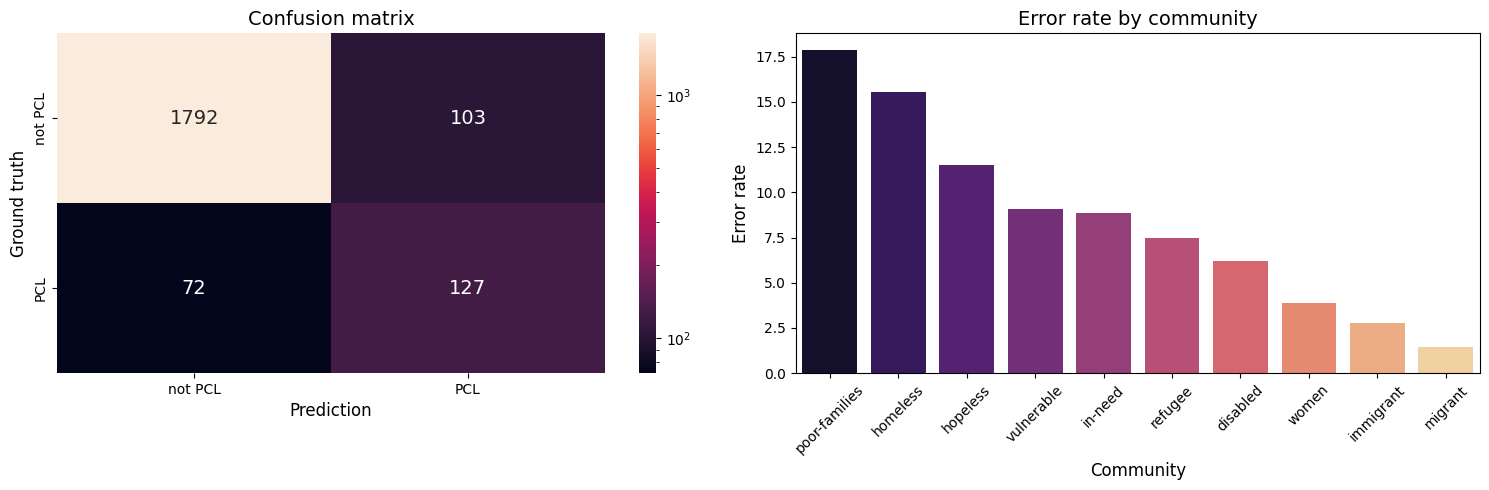

,Community,Total Examples,Errors,Error Rate (%),F1 Score
4,poor-families,190,34,17.89,0.53
3,homeless,212,33,15.57,0.57
0,hopeless,217,25,11.52,0.56
8,vulnerable,209,19,9.09,0.58
2,in-need,226,20,8.85,0.76
1,refugee,188,14,7.45,0.46
9,disabled,194,12,6.19,0.54
5,women,233,9,3.86,0.64
6,immigrant,218,6,2.75,0.40
7,migrant,207,3,1.45,0.67


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
from sklearn.metrics import confusion_matrix

community_stats = []
keywords = val_errors_df['keyword'].unique()

for kw in keywords:
    subset = val_errors_df[val_errors_df['keyword'] == kw]
    total = len(subset)
    errors = len(subset[subset['label'] != subset['prediction']])
    error_rate = errors / total if total > 0 else 0

    kw_f1 = f1_score(subset['label'], subset['prediction'], zero_division=0)

    community_stats.append({
        'Community': kw,
        'Total Examples': total,
        'Errors': errors,
        'Error Rate (%)': error_rate * 100,
        'F1 Score': kw_f1
    })

community_df = pd.DataFrame(community_stats).sort_values(by='Error Rate (%)', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

cm = confusion_matrix(val_errors_df['label'], val_errors_df['prediction'])

sns.heatmap(cm, annot=True, fmt='d',
            norm=LogNorm(), ax=axes[0],
            xticklabels=['not PCL', 'PCL'],
            yticklabels=['not PCL', 'PCL'],
            annot_kws={"size": 14})

axes[0].set_title('Confusion matrix', fontsize=14)
axes[0].set_xlabel('Prediction', fontsize=12)
axes[0].set_ylabel('Ground truth', fontsize=12)

sns.barplot(data=community_df, x='Community', y='Error Rate (%)',
            ax=axes[1], palette='magma')

axes[1].set_title('Error rate by community', fontsize=14)
axes[1].set_xlabel('Community', fontsize=12)
axes[1].set_ylabel('Error rate', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

display(community_df.round(2))